# Churn analysis

In [3]:
#TODO Presenation projet

In [342]:
#
# Import modules
#
import pickle
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Lambda,
    RepeatVector,
    Permute,
    Flatten,
    Activation,
    Multiply,
)
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    auc,
    accuracy_score,
    roc_curve,
    recall_score,
    plot_roc_curve,
    plot_confusion_matrix
)
import warnings

warnings.filterwarnings("ignore")


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 100)
%config IPCompleter.greedy=True

# Exploratory Data Analysis



### Import data

In [7]:
#
# Import data
#
data_path = "churn-media-data/"
users = pd.read_csv(
    data_path + "users.csv.zip",
    compression="zip",
    index_col="uid",
    parse_dates=["registration_date"],
)
logs = pd.read_csv(
    data_path + "usage_logs.csv.zip",
    compression="zip",
    index_col="uid",
    parse_dates=["date"],
)

### Check missing data

<AxesSubplot:ylabel='uid'>

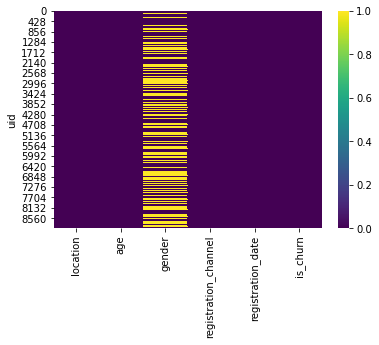

In [18]:
sns.heatmap(users.isna(),cmap ='viridis')

<AxesSubplot:ylabel='uid'>

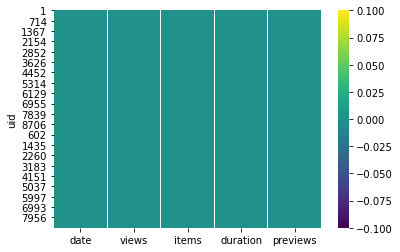

In [19]:
sns.heatmap(logs.isna(),cmap ='viridis')

Nous remarquons beaucoup de missing data dans la colonne Gender, nous pouvons remédier à cela dans le pipeline training.

Aucune data missing dans les logs ( normal)

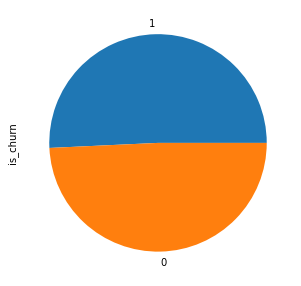

In [20]:
# We have a balanced dataset 

is_churn = users['is_churn'].value_counts()/len(users.is_churn)

plot = is_churn.plot.pie( figsize=(5, 5))

In [165]:
users.columns

Index(['location', 'age', 'gender', 'registration_channel', 'is_churn', 'days_registered'], dtype='object')

In [166]:
#  valeurs abbérantes pour le
users.age.describe()

count    8979.000000
mean       14.868360
std        15.591909
min         0.000000
25%         0.000000
50%        17.000000
75%        27.000000
max        77.000000
Name: age, dtype: float64

In [23]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8979 entries, 0 to 8978
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   location              8979 non-null   int64         
 1   age                   8979 non-null   int64         
 2   gender                4681 non-null   object        
 3   registration_channel  8979 non-null   int64         
 4   registration_date     8979 non-null   datetime64[ns]
 5   is_churn              8979 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 491.0+ KB


In [5]:
users_age = users[users['age'].between(0,90)]

<AxesSubplot:xlabel='age', ylabel='Density'>

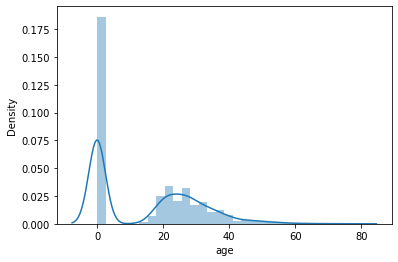

In [6]:
sns.distplot(users_age.age)

In [7]:
print(
    "{:.2%}% of users put 0 as age, they probably didn't want to give their age, we will transform age value to 0 for abberrant values".format(
        sum(users.age == 0) / len(users.age)
    )
)

47.72%% of users put 0 as age, they probably didn't want to give their age, we will transform age value to 0 for abberrant values


<AxesSubplot:xlabel='is_churn', ylabel='age'>

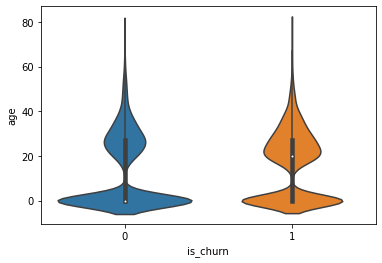

In [8]:
users['age']=  users['age'].apply(lambda x: 0 if(x<0 or x>90) else x)

sns.violinplot(x='is_churn',y='age',data=users)

> No difference

Text(0, 0.5, 'Count')

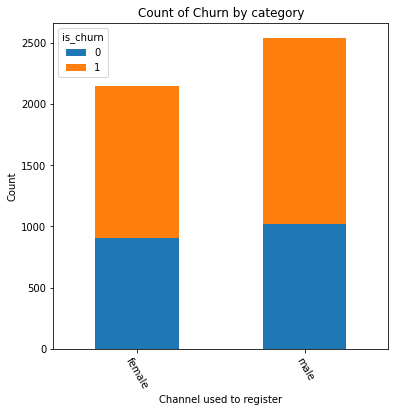

In [9]:
# Count of  churned user by gender
# The na values are automatically
data_req = users.groupby(["gender", "is_churn"]).size().unstack(level=1)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Count of Churn by category")
plt.xlabel("Channel used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)

> No visible difference  by gender 

Text(0, 0.5, 'Count')

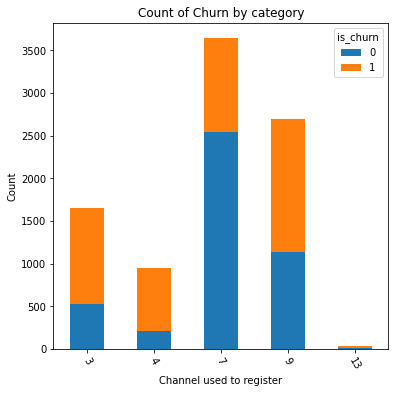

In [10]:
# is churn by registration_channel

data_req = users.groupby(['registration_channel', 'is_churn']).size().unstack(level=1)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Count of Churn by category')
plt.xlabel('Channel used to register', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)

> Notable différence between the churned  categories

Text(0, 0.5, 'Count')

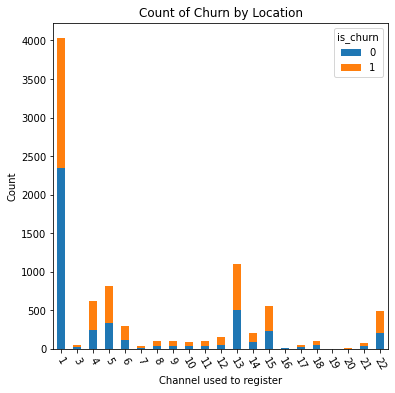

In [125]:
# is churn by location

data_req = users.groupby(['location', 'is_churn']).size().unstack(level=1)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Count of Churn by Location')
plt.xlabel('Channel used to register', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)

> A lot of information coming from the first location

Text(0, 0.5, 'Count')

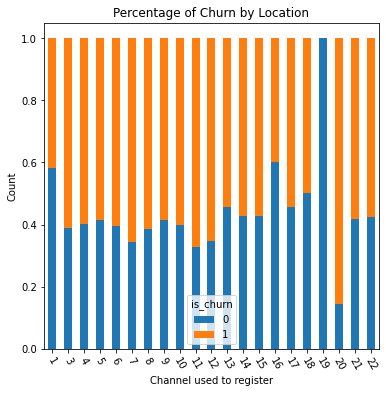

In [104]:
data_req = data_req.divide(users.groupby(['location']).size(),axis=0)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Percentage of Churn by Location')
plt.xlabel('Channel used to register', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)

We have no churn on the 19th location but we only have one data point in location 19 .

In [108]:
users[users['location']==19].count()

location                1
age                     1
gender                  1
registration_channel    1
registration_date       1
is_churn                1
dtype: int64

# Random forest model 

## Feature engineering

In [29]:
print(
    f"Nous avons {np.abs(len(set(logs.index))-len(set(users.index)))} users de différence entre les dataset logs et le dataset user"
)

Nous avons 76 users de différence entre les dataset logs et le dataset user


In [30]:
agg_logs = logs.drop(columns="date").groupby("uid").agg("sum")
agg_logs.head()

,views,items,duration,previews
uid,,,,
0,2634,6640,883533.0,4544
1,22987,24674,6465043.0,7135
2,52439,36158,13512932.0,4897
3,5337,6734,1481273.0,2000
4,20663,18346,5194508.0,7196


In [31]:
# Feature engineering
users['days_registered'] = (pd.Timestamp.now()-users['registration_date']).dt.days
users.drop(columns=['registration_date'],inplace =True)

In [32]:
result = users.join(agg_logs, on='uid')
result.head()

,location,age,gender,registration_channel,is_churn,days_registered,views,items,duration,previews
uid,,,,,,,,,,
0,15,17,female,3,1,2287,2634.0,6640.0,883533.0,4544.0
1,13,40,female,9,0,5357,22987.0,24674.0,6465043.0,7135.0
2,14,23,male,9,1,5054,52439.0,36158.0,13512932.0,4897.0
3,1,19,female,3,1,2275,5337.0,6734.0,1481273.0,2000.0
4,1,0,NaN,9,1,2269,20663.0,18346.0,5194508.0,7196.0


In [33]:
result.shape

(8979, 10)

In [34]:
categorical_features = list(
    result.dtypes.where(result.dtypes == object).dropna().index
) + ["registration_channel","location"]

numeric_features = list(result.dtypes.where(result.dtypes != object).dropna().index)
numeric_features.remove("registration_channel")
numeric_features.remove("location")
numeric_features.remove("is_churn")

features = categorical_features + numeric_features
X = result[features]
y = result["is_churn"]

In [35]:
numeric_transformer = Pipeline(
    steps=[('scaler',StandardScaler()),("imputer", SimpleImputer(strategy="constant", fill_value=0))]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [36]:
print('Training on X  shape : ',X.shape)
print('Training on y  shape : ',y.shape)

Training on X  shape :  (8979, 9)
Training on y  shape :  (8979,)


In [37]:
X_t = preproc.fit_transform(X)
print('Training on X  shape : ',X_t.shape)
print('Training on y  shape : ',y.shape)

Training on X  shape :  (8979, 35)
Training on y  shape :  (8979,)


## Clustering

Text(0.5, 1.0, 'Truncated SVD of representation dataset')

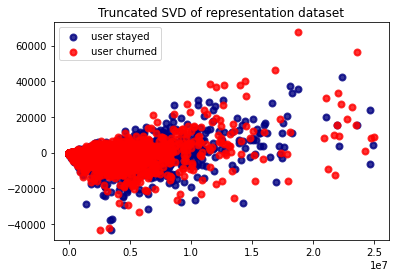

In [209]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

X_r = TruncatedSVD(n_components=2).fit_transform(X_t)

colors = ["navy", "red"]
lw = 2
target_names = ["user stayed", "user churned"]
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
    plt.savefig("TruncatedSVD.png")

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("Truncated SVD of representation dataset")

> No clear clusters at least in 2D

## Model spot checking

### Defining metric 

In our problem we want to detect user suceptible to churn to remedie the problem. 

We need to detect users before they leave , so we need to maximize the recall.  

In [400]:
ml_models = [
    ("dummy_stratified", DummyClassifier(strategy="stratified")),
    ("logistic_reg", LogisticRegression(n_jobs=-1)),
    ("decision_tree", DecisionTreeClassifier(criterion="gini")),
    ("random_forest", RandomForestClassifier(n_jobs=-1)),
]

model_score = {}

for name, model in ml_models:
    scores = cross_val_score(model, X_t, y, scoring="recall", cv=10, n_jobs=-1)
    model_score[name] = {
        "score": scores,
        "mean_score": np.mean(scores),
        "std_score": np.std(scores),
    }

Text(0, 0.5, 'Recall score')

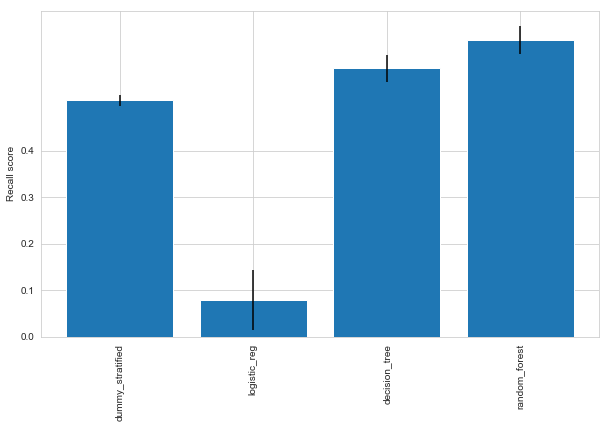

In [403]:
model_results = pd.DataFrame(model_score)

ind = np.arange(model_results.loc["mean_score"].shape[0])
plt.figure(figsize=(10, 6))

plt.bar(
    ind,
    height=model_results.loc["mean_score"].values,
    yerr=model_results.loc["std_score"],
)
plt.xticks(ind, list(res.columns), rotation="vertical")
plt.yticks(np.arange(0, 0.5, 0.1))
plt.ylabel("F0.2 Score")

> Random Forest captures  best the complexity of the model 

### Hyperparameter tuning

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2)

Now that we have chosen our best performing machine learning algorithms, let's combine the methods and tune the parameters

````python
params =  {'random_forest__n_estimators': [500,800,900]}

params = {'random_forest__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'random_forest__max_features': ['auto', 'sqrt'],
 'random_forest__min_samples_leaf': [1, 2, 4],
 'random_forest__min_samples_split': [2, 5, 10],
 'random_forest__n_estimators': [200, 400, 600, 1000, 1200, 1400, 1600, 1800, 2000]}


pipe = Pipeline(steps=[('preprocessor', preproc), ("random_forest", RandomForestClassifier(n_jobs=-1))])
clf = GridSearchCV(pipe, params, cv=3,scoring='recall',n_jobs=-1)
clf.fit(X_train, y_train)

# On local Machine 
params = {"n_estimators": [500, 800, 900]}

clf = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring="recall")
clf.fit(X_train, y_train)

print("Results for Random Forest")
print(clf.best_score_)

print(clf.best_params_)


pkl_filename = "pickled_random_forest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)
````


### Analyzing results

TODO explain this  
* ROC curve 
* Confusion Matrix

In [348]:
pkl_filename = "pickled_random_forest.pkl"

with open(pkl_filename, 'rb') as file:
    clf = pickle.load(file)

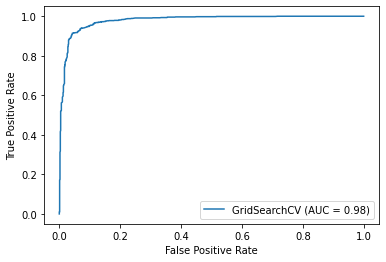

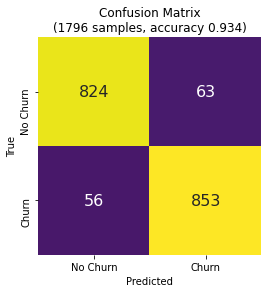

In [349]:
y_pred = clf.predict(X_test)

plot_roc_curve(clf, X_test, y_test)

# Change this function
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="viridis", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, ["No Churn", "Churn"])

In [45]:
ohe = preproc.named_transformers_["cat"].named_steps["onehot"]

feature_names = ohe.get_feature_names(input_features=categorical_features)

feature_names = np.r_[numeric_features, feature_names]

In [46]:
feature_names

array(['age', 'days_registered', 'views', 'items', 'duration', 'previews',
       'gender_Not defined', 'gender_female', 'gender_male',
       'registration_channel_3', 'registration_channel_4',
       'registration_channel_7', 'registration_channel_9',
       'registration_channel_13', 'location_1', 'location_3',
       'location_4', 'location_5', 'location_6', 'location_7',
       'location_8', 'location_9', 'location_10', 'location_11',
       'location_12', 'location_13', 'location_14', 'location_15',
       'location_16', 'location_17', 'location_18', 'location_19',
       'location_20', 'location_21', 'location_22'], dtype=object)

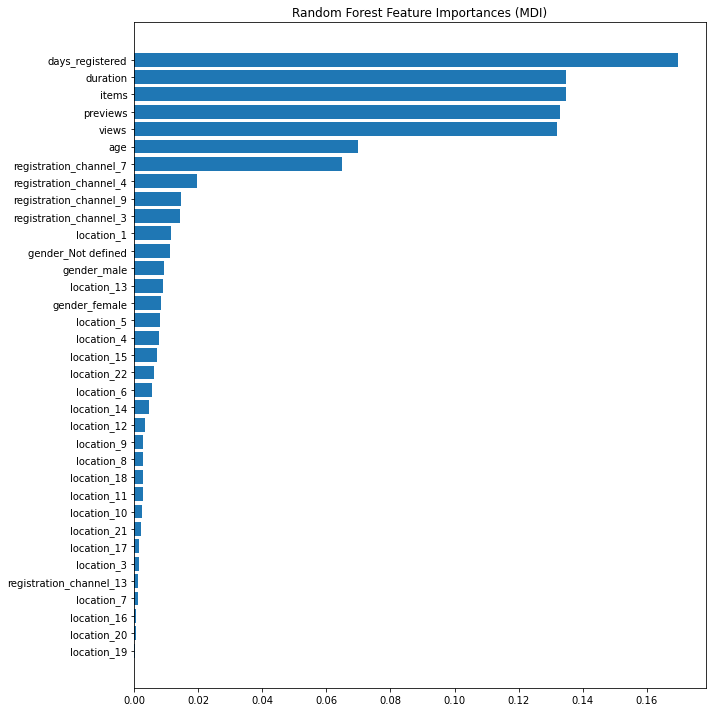

In [49]:
importances = clf.best_estimator_.feature_importances_

sorted_idx = importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(y_ticks, importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

### Further Results 

We see that the 5 most important features are days_registers, duration as the sum of the content viewed, items, and age. We also see that the gender or registration channel are not important enough to predict the churn of a customer. 
> We should focus on getting the customers the best content possible 

In [157]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, scoring="recall", n_jobs=-1
)

In [158]:
# TODO explain this permutation importance

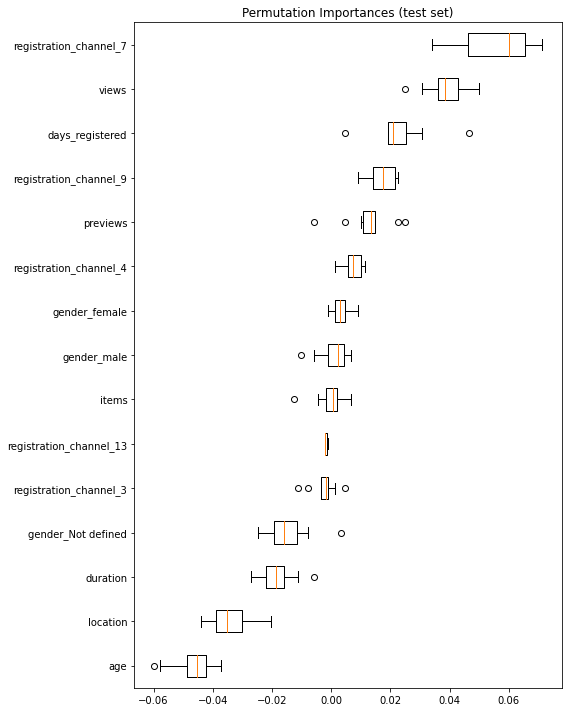

In [159]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 10))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [161]:
# TODO explain this 

# LSTM model with attention

The second step is to build an LSTM model using Keras. We use a model with two inputs:
* One input is a 3D tensor that consist of ordered usage histories aggregated by weeks. This is input is processed by LSTM.
* The second input is the user profile. This input is proceed by a dense layer.

Output of the two submodels are concatenated and processed by several dense layers.

In [19]:
X = pd.DataFrame.sparse.from_spmatrix(X_t, columns=feature_names.tolist())

In [20]:
X.head()

,age,days_registered,views,items,duration,previews,gender_Not defined,gender_female,gender_male,registration_channel_3,registration_channel_4,registration_channel_7,registration_channel_9,registration_channel_13,location_1,location_3,location_4,location_5,location_6,location_7,location_8,location_9,location_10,location_11,location_12,location_13,location_14,location_15,location_16,location_17,location_18,location_19,location_20,location_21,location_22
0,0.108217,-0.340354,-0.447067,-0.104045,-0.421232,0.665778,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.385434,2.590240,1.352034,1.712344,1.595694,1.431703,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.441404,2.300999,3.955440,2.869015,4.142508,0.770128,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.219280,-0.351809,-0.208136,-0.094577,-0.205233,-0.086254,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.835812,-0.357537,1.146604,1.074986,1.136575,1.449736,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA on logs data

Text(0.5, 1.0, 'Distribution of number of log entries per user')

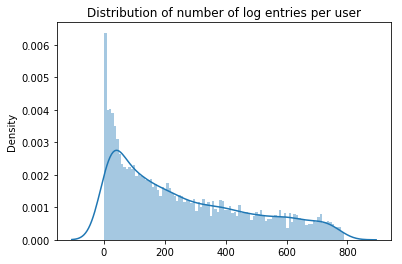

In [15]:
logs_dist =logs.groupby('uid').size()

sns.distplot(logs_dist,bins=100)
plt.title('Distribution of number of log entries per user')

<AxesSubplot:xlabel='date', ylabel='views'>

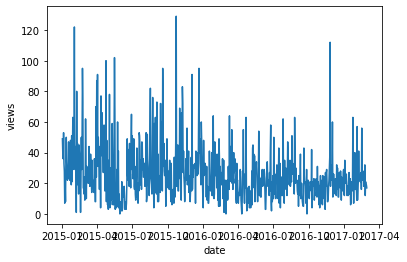

In [28]:
sns.lineplot(x='date',y='views',data=rlogs.loc[id_max])

## Data preparation

We need to capture sequential use in prediction.

Pandas has a problem for upsampling from multiple index data 

Solution add manually the min and max date , then upsample then resample

In [139]:
rlogs = logs.copy()
rlogs = rlogs.reset_index()
rlogs.tail()

,uid,date,views,items,duration,previews
2324209,8977,2016-06-14,8,21,2748.0,20
2324210,8977,2016-08-14,11,15,3175.0,7
2324211,8977,2016-10-25,9,7,2889.0,7
2324212,8977,2016-12-23,3,14,1865.0,16
2324213,8977,2017-02-15,7,8,1655.0,0


In [140]:
min_date=logs.date.min()
max_date=logs.date.max()
have_min_date = rlogs[rlogs.date == min_date].uid.values
have_max_date = rlogs[rlogs.date == max_date].uid.values

In [141]:
pbar = tqdm(set(logs.index))

for uid in pbar :
    pbar.set_description("Processing %s" % uid)
    dict_test={'date':min_date,"uid":uid,'views':0,'items':0,'duration':0,'previews':0}
    rlogs = rlogs.append(dict_test,ignore_index=True)      
    dict_test={'date':max_date,"uid":uid,'views':0,'items':0,'duration':0,'previews':0}
    rlogs = rlogs.append(dict_test,ignore_index=True)

Processing 8978: 100%|██████████| 8903/8903 [26:51<00:00,  5.53it/s]


In [50]:
# rlogs.to_csv('result_pandas.csv')
rlogs = pd.read_csv("result_pandas.csv", parse_dates=True)
rlogs = rlogs.set_index("date")
rlogs.index = pd.to_datetime(rlogs.index)
rlogs.head()

,Unnamed: 0,uid,views,items,duration,previews
date,,,,,,
2015-02-18,0,1,5,10,2126.0,2
2015-04-12,1,1,12,14,3821.0,3
2015-06-01,2,1,4,7,1387.0,2
2015-07-22,3,1,12,30,5713.0,17
2015-09-12,4,1,40,40,10374.0,8


In [51]:
temp = rlogs.groupby('uid').resample('D').asfreq()
temp = temp.fillna(0)
result= temp.iloc[:,2:]
# result.to_csv('padded_logs.csv',index=True,compression="zip")

We need to resample by week to have less time steps in our LSTM

In [52]:
dum = result.reset_index().set_index("date")
dum = dum.groupby("uid").resample("W").sum()
#  dum.to_csv('padded_logs_weekly.csv',index=True, compression="zip")

In [82]:
# dum.to_csv('padded_logs_weekly.csv',index=True)

In [80]:
res = pd.read_csv('padded_logs_weekly.csv',index_col=['uid','date']).iloc[:,1:]

<AxesSubplot:xlabel='date', ylabel='duration'>

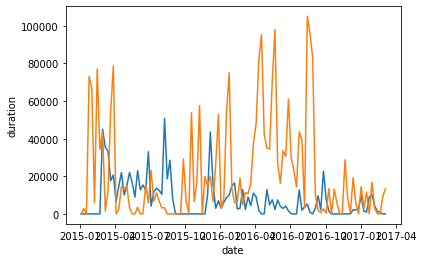

In [99]:
sns.lineplot(x='date',y='duration',data=dum.loc[0])
sns.lineplot(x='date',y='duration',data=dum.loc[456])

## LSTM Input

In [233]:
#  input is of shape : nb_users x events x features
# if users in DF users but no logs , means probably he never connected to the app we will assign to him the null vector
nb_missing_ulogs = (
    users.index.shape[0] - res.index.get_level_values(0).unique().shape[0]
)
print("We have no logs for {} users".format(nb_missing_ulogs))

We have no logs for 76 users


If users in DF users but no logs , means probably he never connected to the app we will assign to him the null vector

In [220]:
nb_users = len(set(users.index))
events = res.loc[0].shape[0]
n_features = res.loc[0].shape[1]
X1 = np.zeros((nb_users, events, n_features))

In [222]:
pbar = tqdm(set(users.index))

for uid in pbar :
    if uid in res.index.get_level_values(0).unique(): 
        X1[uid, : , :] = res_numpy[uid]        

100%|██████████| 8979/8979 [02:15<00:00, 66.37it/s]


In [305]:
print(f'Input tensor shapes: x3d {X1.shape}, x {X_t.shape}, y {y.shape}')

Input tensor shapes: x3d (8979, 114, 4), x (8979, 35), y (8979,)


In [350]:
X_logs_train, X_logs_test, X_train, X_test, y_train, y_test = train_test_split(
    X1, X_t.toarray(), y, test_size=0.2
)

In [351]:
scaler = StandardScaler()
X_logs_train = scaler.fit_transform(X_logs_train.reshape(-1, X_logs_train.shape[-1])).reshape(X_logs_train.shape)
X_logs_test = scaler.transform(X_logs_test.reshape(-1, X_logs_test.shape[-1])).reshape(X_logs_test.shape)

In [352]:
print(f'Input tensors shapes: x3d {X1.shape}, x {X_t.shape}, y {y.shape}')
print("We have {} user's logs and profile for training".format(X_logs_train.shape[0]))
print("And {} user's logs and profile for testing".format(X_logs_test.shape[0]))

Input tensors shapes: x3d (8979, 114, 4), x (8979, 35), y (8979,)
We have 7183 user's logs and profile for training
And 1796 user's logs and profile for testing


## Model 

In [353]:
## Construire class model in separate file
## Explain the attention model

#
# Model parameters
#
hidden_units = 8

#
# Model specification
#
input_logs = Input(shape=(events, n_features))
input_user = Input(shape=(X_t.shape[1],))

# LSTM tower
activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

lstm_tower = Model(inputs=input_logs, outputs=weighted_activations)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top = Dense(32, activation='relu')(combined)
prob_churn = Dense(1, activation='sigmoid')(dense_top)

model = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_churn)

In [354]:
model.summary()

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 114, 4)]     0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 114, 8)       416         input_15[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 114, 1)       9           lstm_7[0][0]                     
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 114)          0           dense_28[0][0]                   
______________________________________________________________________________________

In [355]:
# TODO
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Training

In [333]:
#
# Model training
#
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

model.compile(
    optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", Recall()]
)
history = model.fit(
    [X_logs_train, X_train],
    y_train,
    batch_size=32,
    epochs=20,
    verbose=1,
    validation_data=([X_logs_test, X_test], y_test),
    callbacks=[es]
)

score = model.evaluate([X_logs_test, X_test], y_test, verbose=0)

Epoch 1/20
197/197 [==============================] - 5s 26ms/step - loss: 0.5905 - accuracy: 0.6951 - recall_8: 0.6882 - val_loss: 0.6072 - val_accuracy: 0.6778 - val_recall_8: 0.6851
Epoch 2/20
197/197 [==============================] - 5s 23ms/step - loss: 0.5874 - accuracy: 0.6986 - recall_8: 0.6954 - val_loss: 0.6044 - val_accuracy: 0.6752 - val_recall_8: 0.6604
Epoch 3/20
197/197 [==============================] - 5s 24ms/step - loss: 0.5838 - accuracy: 0.6990 - recall_8: 0.6932 - val_loss: 0.6050 - val_accuracy: 0.6745 - val_recall_8: 0.6705
Epoch 4/20
197/197 [==============================] - 5s 25ms/step - loss: 0.5816 - accuracy: 0.7007 - recall_8: 0.6992 - val_loss: 0.6139 - val_accuracy: 0.6667 - val_recall_8: 0.6219
Epoch 5/20
197/197 [==============================] - 5s 25ms/step - loss: 0.5793 - accuracy: 0.7017 - recall_8: 0.6986 - val_loss: 0.6042 - val_accuracy: 0.6778 - val_recall_8: 0.6633
Epoch 6/20
197/197 [==============================] - 6s 30ms/step - loss: 

In [310]:
model.save_weights('attention_model_weight.h5')
model.save("attention_model.h5")

### Training supervision 

In [334]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_8', 'val_loss', 'val_accuracy', 'val_recall_8'])

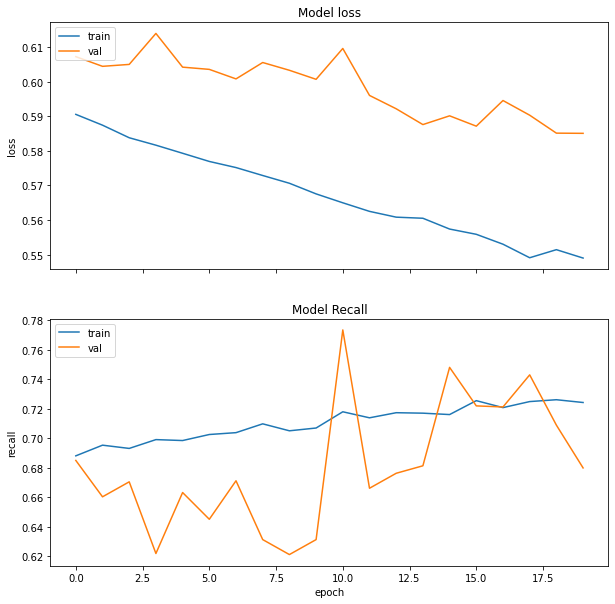

In [336]:
fig, axs =plt.subplots(2,1,sharex=True,figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('loss')
axs[0].legend(['train', 'val'], loc='upper left')

axs[1].plot(history.history['recall_8'])
axs[1].plot(history.history['val_recall_8'])
axs[1].set_title('Model Recall')
axs[1].set_ylabel('recall')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')



In [ ]:
y_pred = clf.predict(X_test)

plot_roc_curve(clf, X_test, y_test)

# Change this function
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="viridis", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()
    
plot_confusion_matrix(y_test, y_pred, ["No Churn", "Churn"])

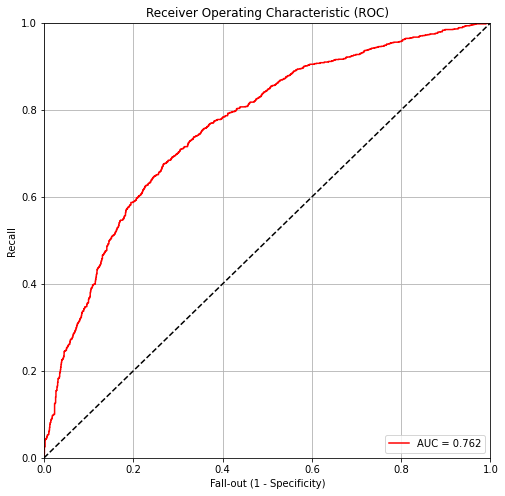

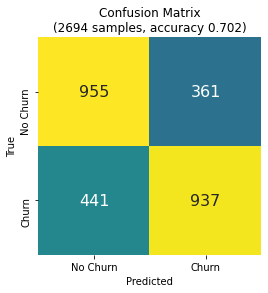

In [346]:
y_pred = model.predict([X_logs_test, X_test])

# plot ROC
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(8, 8))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.show()
    
plot_roc( y_test,y_pred)

# plot confusion matrix
plot_confusion_matrix(y_test, y_pred, ['No Churn', 'Churn'])